In [1]:
#########################################################################
# 01. Libraries

import os
import pandas as pd
import numpy as np
import random
np.random.seed(12)

import seaborn as sns
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.decomposition import PCA

import math
from tqdm import tqdm
from operator import itemgetter 

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras import regularizers as reg

import multiprocessing
import gc
# https://omoindrot.github.io/triplet-loss
# https://www.kaggle.com/sandy1112/create-and-train-resnet50-from-scratch - Good Generator

#########################################################################

C:\Users\Enric\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20200727). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
#########################################################################
# 02. Load Data & Preprocess Data

# Train df

df_train = pd.read_csv('./train.csv')

print(df_train.shape)
print(f'1. -> There are {df_train.landmark_id.unique().shape[0]} unique landmarks')

# Images

train_paths = glob.glob('./train/*/*/*/*')
test_paths = glob.glob('./test/*/*/*/*')
index_paths = glob.glob('./index/*/*/*/*')

print(f'No. of Index Images : {len(index_paths)}')
print(f'No. of Train Images : {len(train_paths)}')
print(f'No. of Test Images : {len(test_paths)}')


# t=pd.DataFrame({"train_path":train_paths})
# t["id"]=t["train_path"].apply(lambda x: x.split("/")[-1][:-4])
# df_train=df_train.merge(t, how='inner',on=["id"])

# # Images Classes from: https://www.kaggle.com/sudeepshouche/identify-landmark-name-from-landmark-id

url = 'https://s3.amazonaws.com/google-landmark/metadata/train_label_to_category.csv'
dict_class = pd.read_csv(url, index_col = 'landmark_id', encoding='latin', engine='python')['category'].to_dict()

# # Only keep landmarks with 4 imgs or more

# series_groupby = df_train.groupby(['landmark_id'])['id'].count().sort_values()
# df_count_images_landmark = pd.DataFrame({
#     'landmark_id' : series_groupby.index,
#     'qt_images' : series_groupby.values
# })

# df_train = df_train.merge(df_count_images_landmark, how='inner')
# # df_train = df_train[df_train['qt_images']>=5]

# print(f'2. -> After filtering there are {df_train.landmark_id.unique().shape[0]} unique landmarks')

#########################################################################

(1580470, 2)
1. -> There are 81313 unique landmarks
No. of Index Images : 76176
No. of Train Images : 1580470
No. of Test Images : 1129


In [3]:
##########################################################################
# 03. Functions

# Plot imgs from an input landmark class in train folder

def printImg(class_id, df_landmarks, dict_class, figsize, max_rows=12, max_cols=3, img_size=(120, 120)):
    file_path = "./train/"
    df_landmarks = df_landmarks[df_landmarks['landmark_id'] == class_id].reset_index()
    
    print("Class {} - {}".format(class_id, dict_class[class_id].split(':')[-1]))
    print("Number of images: {}".format(len(df_landmarks)))
    
    plt.rcParams["axes.grid"] = False
    no_row = math.ceil(min(len(df_landmarks), max_rows)/max_cols) 
    f, axarr = plt.subplots(no_row, max_cols, figsize=figsize)

    curr_row = 0
    len_img = min(max_rows, len(df_landmarks))
    for i in range(len_img):
        img_name = df_landmarks['id'][i] + ".jpg"
        img_path = os.path.join(file_path, img_name[0], img_name[1], img_name[2], img_name)
        example = cv2.imread(img_path)
        example = cv2.resize(example, (img_size[0], img_size[1]), interpolation = cv2.INTER_AREA)
        # uncomment the following if u wanna rotate the image
        # example = cv2.rotate(example, cv2.ROTATE_180)
        example = example[:,:,::-1]

        col = i % 3
        axarr[curr_row, col].imshow(example)
        axarr[curr_row, col].set_title("{}. {} ({})".format(class_id, dict_class[class_id].split(':')[-1], df_landmarks['id'][i]))
        if col == 2:
            curr_row += 1
            
# Plot imgs from input folder {train, test, index}

def plotFolderImages(list_folder_imgs, max_imgs = 12):
    plt.rcParams["axes.grid"] = False
    f, axarr = plt.subplots(4, 3, figsize=(24, 22))

    curr_row = 0
    for i in range(max_imgs):
        example = cv2.imread(list_folder_imgs[i])
        # uncomment the following if u wanna rotate the image
        # example = cv2.rotate(example, cv2.ROTATE_180)
        example = example[:,:,::-1]

        col = i % 4
        axarr[col, curr_row].imshow(example)
        axarr[col, curr_row].set_title(list_folder_imgs[i])
        if col == 3:
            curr_row += 1
            
            
def decodeImage(filename, image_size=(240, 240), numpy=True):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)# / 255.0
    image = tf.image.resize(image, image_size)
    if numpy:
        return image.numpy()
    return image
            
            
##########################################################################

In [4]:
##########################################################################
# 04. Preprocessing

# thresh = 100 -> 90mins
df_train_preprocessed = pd.read_csv('./train_preprocessed_30imgs.csv')

df_train_preprocessed['train_path_local'] = df_train_preprocessed['train_path'].apply(lambda x: "./" + "/".join(x.split('/')[3:]))
# threshold = 30
# img_size = (100, 100, 3)

# landmarks_upper_threshold = set(df_count_images_landmark['landmark_id'][df_count_images_landmark['qt_images']>=threshold].values)
# dict_landmark_to_ids = df_train.groupby("landmark_id")["id"].apply(list).to_dict()
# dict_id_to_path = df_train.set_index("id")["train_path"].to_dict()

# for i, landmark in tqdm(enumerate(landmarks_upper_threshold), total=len(landmarks_upper_threshold)):
#     landmark_ids = dict_landmark_to_ids[landmark]
#     landmark_ids_paths = [dict_id_to_path[landmark] for landmark in landmark_ids]
#     n_components = len(landmark_ids_paths) - 10
    
#     images = [decodeImage(img_path, (img_size[0], img_size[1]), numpy=True).flatten() for img_path in landmark_ids_paths]
#     pca_model = PCA(n_components = n_components)
#     pca_model.fit(images)
# #     print(f'Components: {n_components}, Explained variance: {pca_model.explained_variance_ratio_.sum()}')
#     images_components = pca_model.transform(images)
    
#     knn_model = NearestNeighbors(n_neighbors=images_components.shape[0], metric="euclidean")
#     knn_model.fit(images_components)
#     distances, indices = knn_model.kneighbors(images_components)
#     unique_, counts_ = np.unique(indices[:, 1], return_counts=True)
#     centroid =  counts_.argmax()
#     # Get images that are further to the centroid
#     keep_images = distances[:, centroid].argsort()[::-1][:threshold]
#     # Fast way to get elements from a list using indexes
#     if i==0:
#         list_keep_imgs_ids = list(itemgetter(*keep_images)(landmark_ids))
#     else:
#         list_keep_imgs_ids.extend(list(itemgetter(*keep_images)(landmark_ids)))
 

# df_landmarks_upper_threshold_all = df_train[df_train['qt_images']>=threshold]
# df_landmarks_upper_threshold_keep = pd.DataFrame({'id': list_keep_imgs_ids})

# df_landmarks_upper_threshold = df_landmarks_upper_threshold_all.merge(df_landmarks_upper_threshold_keep, how='inner')
# df_train_preprocessed = pd.concat([df_train[df_train['qt_images']<threshold], df_landmarks_upper_threshold], axis=0)
# print(f'Original images: {df_landmarks_upper_threshold_all.shape[0]}, keep images: {df_landmarks_upper_threshold_keep.shape[0]}, Images of final df: {df_landmarks_upper_threshold.shape[0]}')
# print(f'Original train size: {df_train.shape[0]}, New df size: {df_train_preprocessed.shape[0]}')
# print(f'Reduction={df_train.shape[0] - df_train_preprocessed.shape[0]} images')

# df_train_preprocessed .to_csv('./train_preprocessed.csv', index=False)

##########################################################################

Class 1981 - Kloster_Eibingen
Number of images: 25


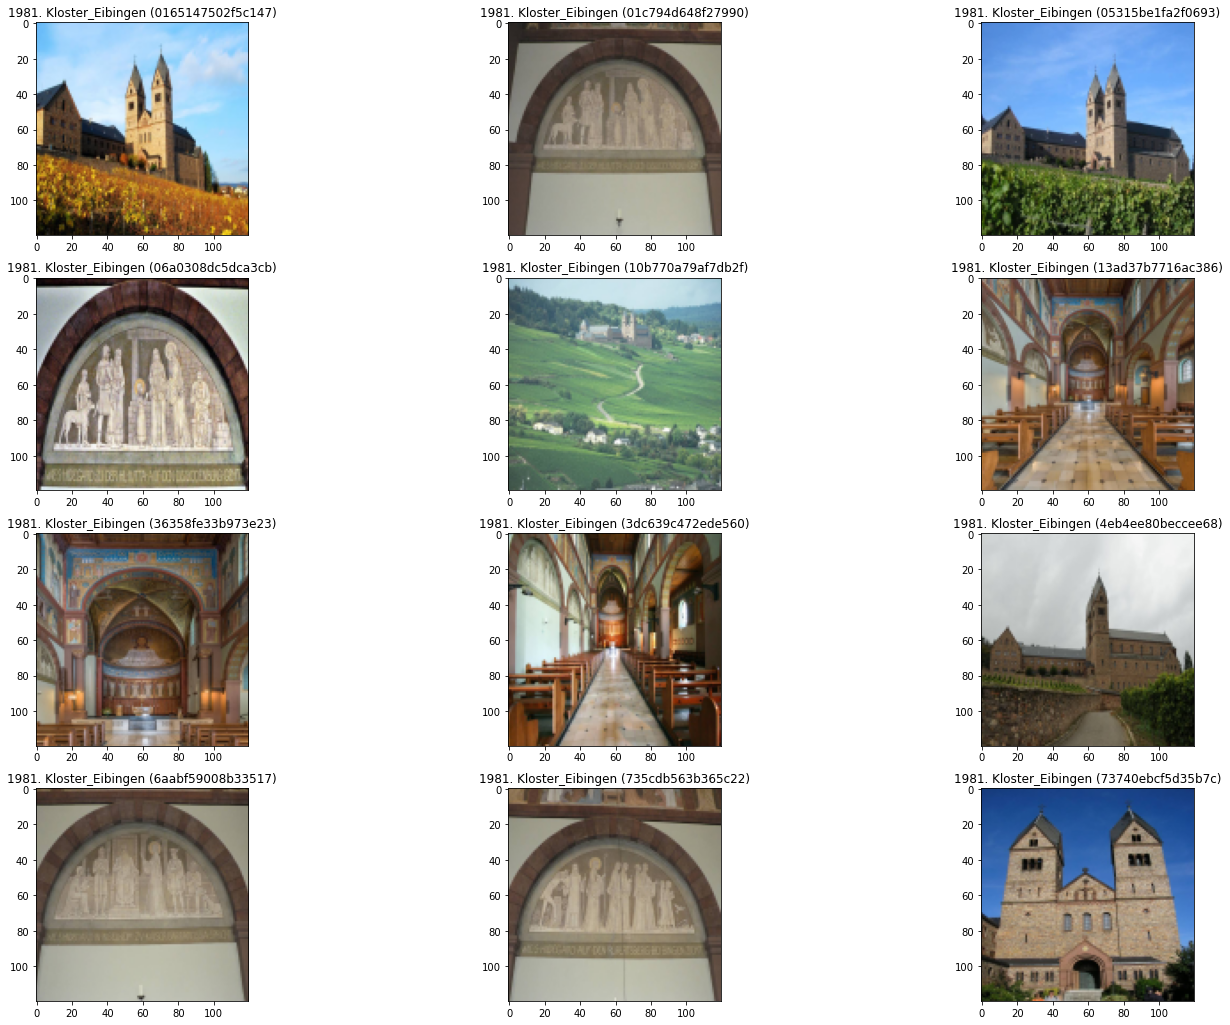

In [5]:
##########################################################################
# 04. Look up

printImg(class_id=1981, df_landmarks=df_train_preprocessed, dict_class=dict_class, figsize=(24, 18), img_size=(120, 120))
# plotFolderImages(index_paths)

##########################################################################

In [6]:
##########################################################################
# 05. Classes

class SimilDataGenerator(Sequence):
    
    def __init__(self, df_train, batch_size, img_size_load=(250, 250, 3), img_size_crop=(224, 224, 3)):
        super().__init__()
        self.df_train = df_train
        self.batch_size = batch_size
        self.img_size_load = img_size_load
        self.img_size_crop = img_size_crop
        
        self.dict_id_to_landmark = self.df_train.set_index("id")["landmark_id"].to_dict()
        self.dict_landmark_to_ids = self.df_train.groupby("landmark_id")["id"].apply(list).to_dict()
        self.dict_id_to_path = self.df_train.set_index("id")["train_path_local"].to_dict()
        self.dict_landmark_to_count = self.df_train.set_index("landmark_id")["qt_images"].to_dict()
        
        self.ids = list(self.df_train['id'].unique())
        self.landmark_ids = set(self.df_train['landmark_id'].unique())
        self.num_steps = math.ceil(len(self.ids) / self.batch_size)
        self.on_epoch_end()
      
    # Number of batches in the sequence
    
    def __len__(self):
        return self.num_steps
    
    # Gets the batch at position index
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        anchors_ids = [self.ids[k] for k in indexes] 
        positives_ids = [self.get_positives(anchor) for anchor in anchors_ids]
        negatives_ids = [self.get_negatives(anchor) for anchor in anchors_ids]
        
        X = [anchors_ids, positives_ids, negatives_ids]
        X = self.get_images(X)
        y = np.asarray([self.dict_id_to_landmark[anchor] for anchor in anchors_ids])
        assert X[0].shape==X[1].shape==X[2].shape
        return X, y
        
    
    # We shuffle the data at the end of each epoch
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        np.random.shuffle(self.indexes)
            
    
    # Given an anchor return ids of the same landmark
    
    def get_positives(self, anchor):
        landmark = self.dict_id_to_landmark[anchor]
        landmark_positives_images = self.dict_landmark_to_ids[landmark]
        landmark_positives_images = [positive_img for positive_img in landmark_positives_images if positive_img != anchor]
        return np.random.choice(landmark_positives_images)
        
    # Given an anchor return ids of different landmark
    
    def get_negatives(self, anchor):
        landmark = self.dict_id_to_landmark[anchor]
        landmark_negative_images = random.sample(list(self.landmark_ids - set([anchor])), 1)[0]
        landmark_negative_images = self.dict_landmark_to_ids[landmark_negative_images]
        return np.random.choice(landmark_negative_images)
    
    # Return a tuple of images from class dicts
    
    def get_images(self, X):
        anchors_ids, positives_ids, negatives_ids, X_anchors, X_positives, X_negatives = X[0], X[1], X[2], [], [], []
        
        for a, p, n in zip(anchors_ids, positives_ids, negatives_ids):
            a = decodeImage(self.dict_id_to_path[a], (self.img_size_load[0], self.img_size_load[1]), numpy=True)
            p = decodeImage(self.dict_id_to_path[p], (self.img_size_load[0], self.img_size_load[1]), numpy=True)
            n = decodeImage(self.dict_id_to_path[n], (self.img_size_load[0], self.img_size_load[1]), numpy=True)
            X_anchors.append(a)
            X_positives.append(p)
            X_negatives.append(n)
        X_anchors = [tf.image.random_crop(img, (self.img_size_crop[0], self.img_size_crop[1], 3)).numpy() for img in X_anchors]  
        X_positives = [tf.image.random_crop(img, (self.img_size_crop[0], self.img_size_crop[1], 3)).numpy() for img in X_positives]  
        X_negatives = [tf.image.random_crop(img, (self.img_size_crop[0], self.img_size_crop[1], 3)).numpy() for img in X_negatives]  

        return [np.array(X_anchors), np.array(X_positives), np.array(X_negatives)]
    
    
class GeMPoolingLayer(tf.keras.layers.Layer):
    
    def __init__(self, p=1., train_p=False):
        super().__init__(name='GeMPool')
        if train_p:
            self.p = tf.Variable(p, dtype=tf.float32)
        else:
            self.p = p
        self.eps = 1e-6

    def call(self, inputs: tf.Tensor, **kwargs):
        inputs = tf.clip_by_value(inputs, clip_value_min=1e-6, clip_value_max=tf.reduce_max(inputs))
        inputs = tf.pow(inputs, self.p)
        inputs = tf.reduce_mean(inputs, axis=[1, 2], keepdims=False)
        inputs = tf.pow(inputs, 1./self.p)
        return inputs

    
    
class ResNet(models.Model):
    
    def __init__(self, pretrained=False, img_size=(220, 220, 3)):
        super(ResNet, self).__init__(name='ResNet')
        self.pretrained = pretrained
        self.img_size = img_size
        self.base_model = ResNet50(weights="imagenet", include_top=False, 
                                   input_tensor=layers.Input(shape=(None, None, 3)))
        self.trainable_layers = [layer_ for i, layer_ in enumerate(self.base_model.layers) if layer_.name.split('_')[0] != 'conv5']
        self.result_model = models.Model(inputs=self.trainable_layers[0].input, outputs=self.trainable_layers[-1].output)
#         self.result_model = self.base_model
        if self.pretrained:
            for layer in self.result_model.layers:
                layer.trainable = False
            
        self.glob_pool = GeMPoolingLayer(p=3, train_p=True)
        self.dropout_2 = layers.Dropout(0.4)
        self.dense_2 = layers.Dense(1024, activation=None, name='output_dense')
        self.latent_dim = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='output_latent')
        
    def call(self, inputs):
        # backbone model
        x = tf.keras.applications.resnet.preprocess_input(inputs)
        x = self.result_model(x)
        
        # output
        x = self.glob_pool(x)

        x = self.dropout_2(x)
        x = self.dense_2(x)
        x = self.latent_dim(x)
        
        return x

    
def onlineTripletLoss(y_true, y_pred, hard_neg=False, margin = 1.0):

    anchor_output, positive_output, negative_output = y_pred[0], y_pred[1], y_pred[2]
    
    d_pos = tf.reduce_sum(tf.square(tf.subtract(anchor_output, positive_output)), 1)
    if hard_neg:
        d_neg = tf.reduce_min(tf.square(tf.subtract(anchor_output, negative_output)), 1)
    else:
        d_neg = tf.reduce_sum(tf.square(tf.subtract(anchor_output, negative_output)), 1)

    loss = tf.add(tf.subtract(d_pos, d_neg), margin)
    loss = tf.reduce_mean(tf.maximum(0.0, loss))
    
    return loss



# Model functions

def buildSimilNet(pretrained=False, margin=1.0, img_size=(240, 240, 3)):
    anchor_input = layers.Input(shape=(None, None, 3))
    positive_input = layers.Input(shape=(None, None, 3))
    negative_input = layers.Input(shape=(None, None, 3))
    
  
    convmodel = ResNet(pretrained=pretrained, img_size=img_size)
    anchor_out = convmodel(anchor_input)
    positive_out = convmodel(positive_input)
    negative_out = convmodel(negative_input)
    
    latent_vec = tf.stack([anchor_out, positive_out, negative_out])
    
    model = models.Model(inputs=[anchor_input, positive_input, negative_input],
                         outputs=latent_vec)
    
    embedding_model = models.Model(inputs=anchor_input, outputs=anchor_out)
    model.compile(loss=onlineTripletLoss , optimizer=optimizers.Adam(0.001, beta_1=0.9, beta_2=0.995))
    
    return model, embedding_model



class LandmarkRetrievalModel(tf.Module):
    def __init__(self, model, img_size):
        super(LandmarkRetrievalModel, self).__init__()
        self.model = model
        self.img_size = img_size
    
    @tf.function(input_signature=[
      tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8, name='input_image')
    ])
    
    def call(self, input_image):
        output_tensors = {}
        # Add batch dimension
        x = tf.expand_dims(input_image, 0, name='input_image')
        x = tf.image.resize(x, (self.img_size[0], self.img_size[1]))
        x = self.model(x)
#         x = tf.math.l2_normalize(x)
        x = tf.squeeze(x, axis=0) #, name='encoding_flat')
        
        output_tensors['global_descriptor'] = tf.identity(x, name='global_descriptor')
        return output_tensors


class predictDataset(Sequence):
    def __init__(self, paths, batch_size, img_size_load, img_size_crop):
        self.paths=paths
        self.batch_size=batch_size
        self.img_size_load=img_size_load
        self.img_size_crop=img_size_crop
        self.on_epoch_end()
        
    def __len__(self,):
        return math.ceil(len(self.paths) / self.batch_size)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.paths))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        images=[self.paths[t] for t in indexes]
        images = [decodeImage(t, (self.img_size_load[0], self.img_size_load[1]), numpy=True) for t in images]
        images = [tf.image.random_crop(img, (self.img_size_crop[0], self.img_size_crop[1], 3)).numpy() for img in images]  
#         images=[cv2.imread(t) for t in images]
#         images=[cv2.resize(t, (self.img_size[0], self.img_size[1]))/255 for t in images]
        return np.asarray(images)


##########################################################################

In [7]:
# base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=layers.Input(shape=(None, None, 3)))
# # [layer_.name for i, layer_ in enumerate(base_model.layers) if layer_.name.split('_')[0] != 'conv5']
# result_model = models.Model(inputs=base_model.layers[0].input, outputs=base_model.get_layer('conv4_block6_out').output)
# glob_avg_pool = layers.GlobalAvgPool2D()
# for layer in result_model.layers:
#     layer.trainable = False


In [8]:
# dict_landmark_to_ids = df_train_preprocessed.groupby("landmark_id")["id"].apply(list).to_dict()
# dict_id_to_path = df_train_preprocessed.set_index("id")["train_path_local"].to_dict()

# landmarks = np.random.choice(list(dict_landmark_to_ids.keys()), size=32)
# query_imgs = np.asarray([decodeImage(dict_id_to_path[dict_landmark_to_ids[landmark][0]], (img_size[0], img_size[1]), numpy=True) for landmark in landmarks])

# plt.imshow(query_imgs[1]/255)
# plt.show()
# plt.imshow(tf.image.random_crop(query_imgs[1], size=[220, 220, 3])/255)
# plt.show()


In [ ]:
##########################################################################
# Model

batch_size = 32
epochs = 2
img_size_load=(250, 250, 3)
img_size_crop=(224, 224, 3)

X_train_generator = SimilDataGenerator(df_train_preprocessed, batch_size, img_size_load=img_size_load, 
                                       img_size_crop=img_size_crop)
# df_train_preprocessed ,# df_train

model, embedding_model = buildSimilNet(pretrained=True, margin=1.0, img_size=img_size_crop)

print(model.summary())
print(model.layers[3].summary())

qt_processors = multiprocessing.cpu_count() # - 1

history = model.fit(
    X_train_generator,
    #validation_data=X_val_generator,
#     batch_size=batch_size,
    use_multiprocessing=False,
    workers=qt_processors,
    epochs=epochs,
    verbose=1
) 

##########################################################################

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
ResNet (ResNet)                 (None, 1024)         24637313    input_1[0][0]                    
                                                                 input_2[0][0]         

Epoch 1/2


In [10]:
# 461/16411 [..............................] - ETA: 11:40:27 - loss: 0.3499
# 4364/16411 [======>.......................] - ETA: 7:56:35 - loss: 0.2804 # p = 3
# 7982/16411 [=============>................] - ETA: 5:20:43 - loss: 0.2572
# 11657/16411 [====================>.........] - ETA: 3:11:28 - loss: 0.2517

##########################################################################

2
anchor


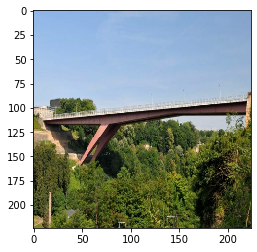

positive


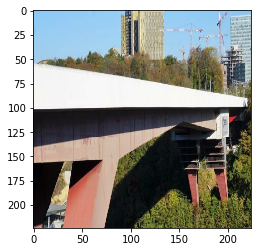

negative


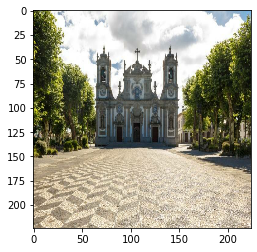

In [11]:
X_train_generator = SimilDataGenerator(df_train_preprocessed, batch_size, img_size_load=img_size_load, 
                                       img_size_crop=img_size_crop)
for batch in X_train_generator:
    break
print(len(batch))
print('anchor')
plt.imshow(batch[0][0][0, :, :, :]/255)
plt.show()
print('positive')
plt.imshow(batch[0][1][0, :, :, :]/255)
plt.show()
print('negative')
plt.imshow(batch[0][2][0, :, :, :]/255)
plt.show()

In [12]:
# del series_groupby, batch, t, df_train, train_paths, X_train_generator, images
# gc.collect()

In [13]:
# landmarks = np.random.choice(list(dict_landmark_to_ids.keys()), size=32)
# query_imgs = np.asarray([decodeImage(dict_id_to_path[dict_landmark_to_ids[landmark][0]], (img_size[0], img_size[1]), numpy=True) for landmark in landmarks])

# embs_anchor = embedding_model.predict(query_imgs)
# embs_pos = embs_anchor + np.random.uniform(-0.2, 0.2, size=128)
# embs_neg = embs_anchor + np.random.uniform(-0.2, 0.2, size=128)

# embs shape = [batch, latent_dim]

In [14]:
# d_pos = tf.reduce_sum(tf.square(tf.subtract(embs_anchor, embs_pos)), 1)
# d_neg = tf.square(tf.subtract(embs_anchor, embs_pos))
# min_distances = tf.argmin(d_neg, 1)
# d_neg = tf.reduce_sum(d_neg[min_distances], 1)
# tf.reduce_sum(tf.square(tf.subtract(embs, embs + np.random.uniform(-0.2, 0.2, size=128))), 1)

Distance 1-2: 0.7217810750007629
Distance 1-3: 1.4228088855743408
Distance 1-4: 1.5785950422286987


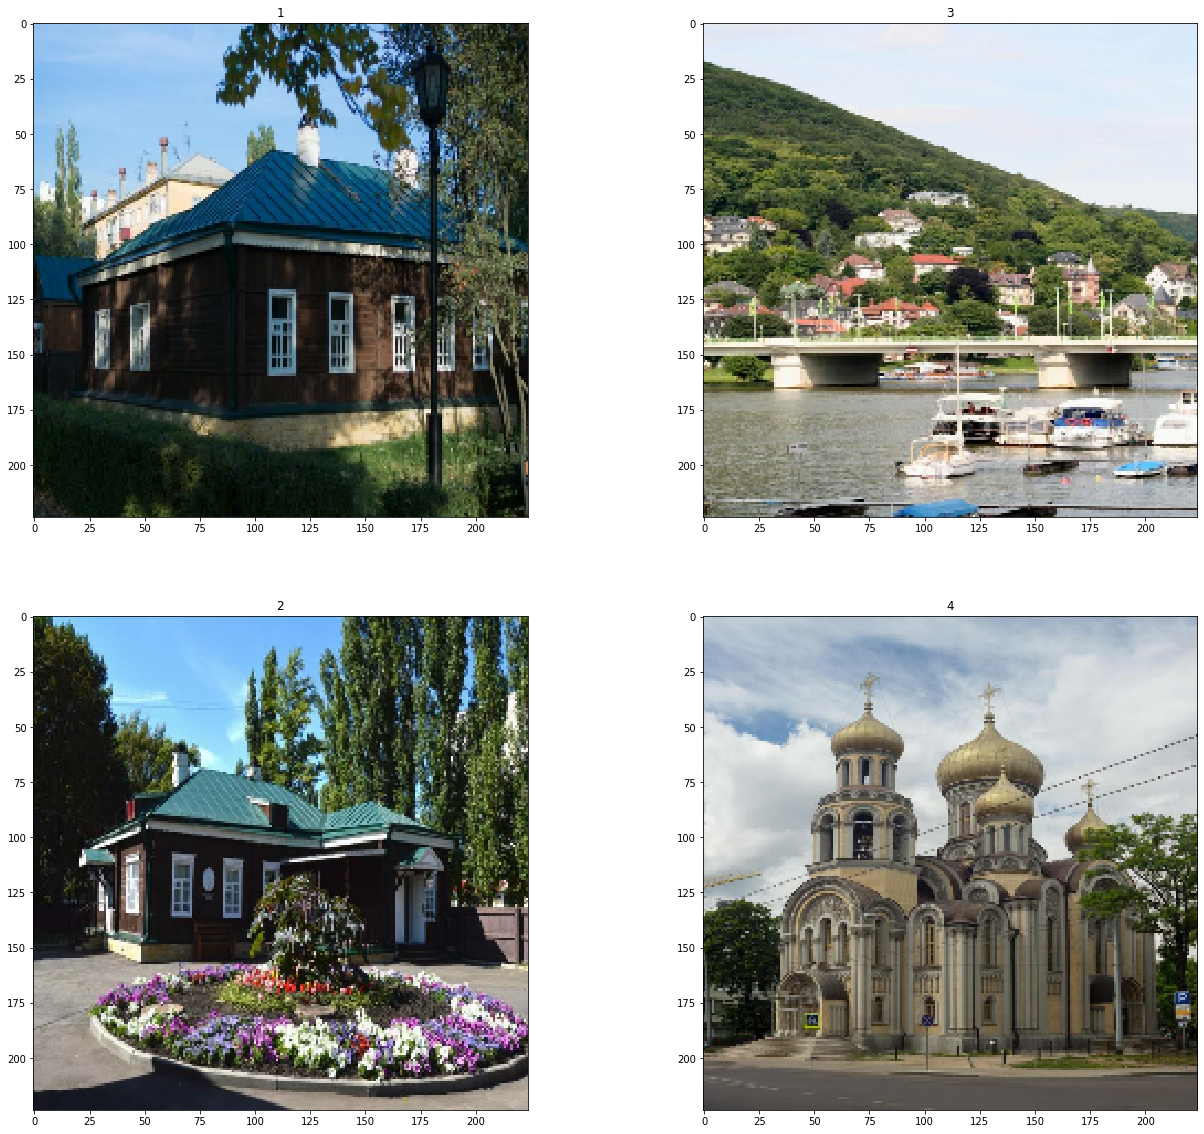

In [16]:
import scipy

dict_landmark_to_ids = df_train_preprocessed.groupby("landmark_id")["id"].apply(list).to_dict()
dict_id_to_path = df_train_preprocessed.set_index("id")["train_path_local"].to_dict()

landmark = np.random.choice(list(dict_landmark_to_ids.keys()))

query_img1 = decodeImage(dict_id_to_path[dict_landmark_to_ids[landmark][0]], (img_size_crop[0], img_size_crop[1]), numpy=True)
query_img2 = decodeImage(dict_id_to_path[dict_landmark_to_ids[landmark][1]], (img_size_crop[0], img_size_crop[1]), numpy=True)
query_img3 = decodeImage(train_paths[2], (img_size_crop[0], img_size_crop[1]), numpy=True)
query_img4 = decodeImage(train_paths[4], (img_size_crop[0], img_size_crop[1]), numpy=True)


emb1 = embedding_model.predict(np.expand_dims(query_img1, axis=0))
emb2 = embedding_model.predict(np.expand_dims(query_img2, axis=0))
emb3 = embedding_model.predict(np.expand_dims(query_img3, axis=0))
emb4 = embedding_model.predict(np.expand_dims(query_img4, axis=0))

f, axarr = plt.subplots(2, 2, figsize=(22, 20))
imgs = [query_img1, query_img2, query_img3, query_img4]
curr_row = 0
for i in range(4):
    col = i % 2
    axarr[col, curr_row].imshow(imgs[i]/255)
    axarr[col, curr_row].set_title(i+1)
    if i==1:
        curr_row+=1
    
print(f'Distance 1-2: {scipy.spatial.distance.euclidean(emb1, emb2)}')
print(f'Distance 1-3: {scipy.spatial.distance.euclidean(emb1, emb3)}')
print(f'Distance 1-4: {scipy.spatial.distance.euclidean(emb1, emb4)}')


# print(f'Distance 1-2: {scipy.spatial.distance.euclidean(tf.math.l2_normalize(emb1), tf.math.l2_normalize(emb2))}')
# print(f'Distance 1-3: {scipy.spatial.distance.euclidean(tf.math.l2_normalize(emb1), tf.math.l2_normalize(emb3))}')
# print(f'Distance 1-4: {scipy.spatial.distance.euclidean(tf.math.l2_normalize(emb1), tf.math.l2_normalize(emb4))}')

Query image: 


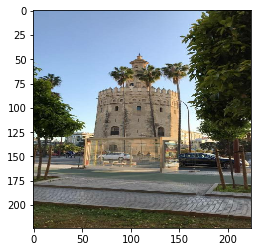

1 - Match index: 
Distance=0.6068704994612466


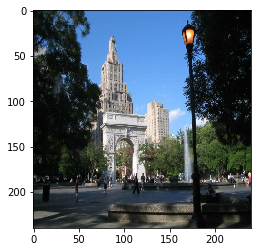

2 - Match index: 
Distance=0.6332895911845294


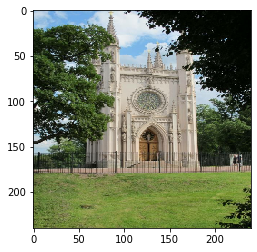

3 - Match index: 
Distance=0.6471049697513054


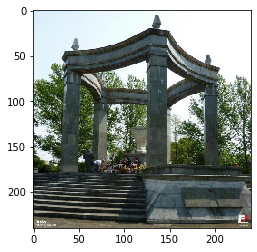

Query image: 


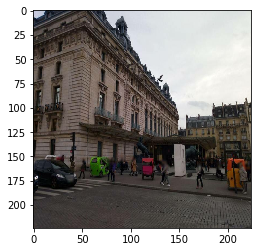

1 - Match index: 
Distance=0.4117583675345223


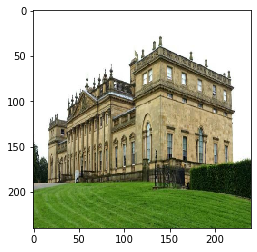

2 - Match index: 
Distance=0.42675935826196265


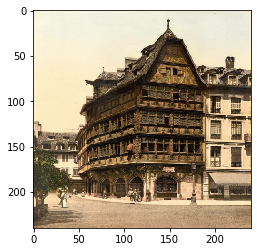

3 - Match index: 
Distance=0.4429716593357542


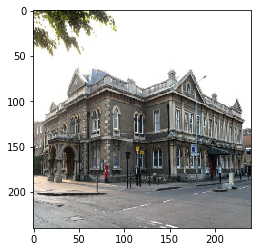

Query image: 


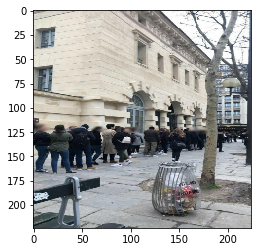

1 - Match index: 
Distance=0.46178396708606945


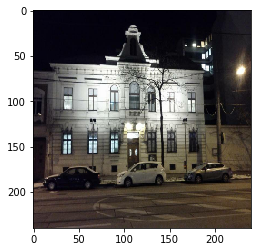

2 - Match index: 
Distance=0.4913439499050645


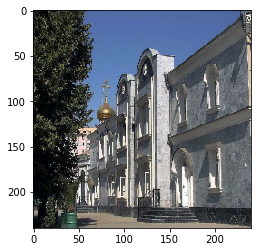

3 - Match index: 
Distance=0.5492444854147223


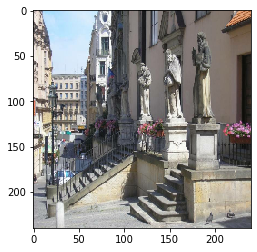

Query image: 


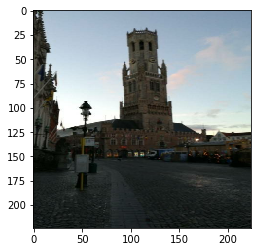

1 - Match index: 
Distance=0.5522273125802079


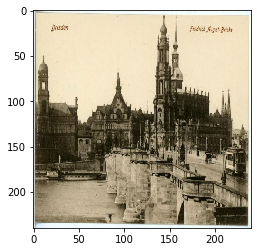

2 - Match index: 
Distance=0.5853409180325223


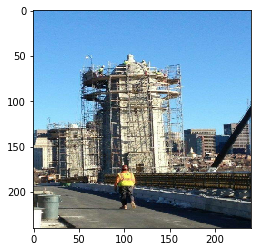

3 - Match index: 
Distance=0.5860010991275069


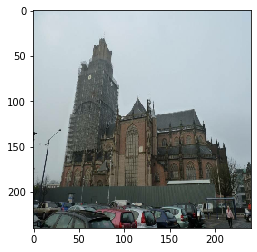

Query image: 


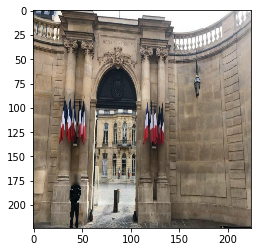

1 - Match index: 
Distance=0.41401195372698374


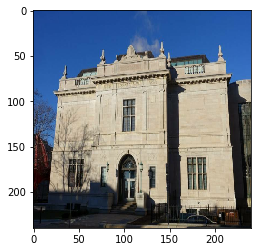

2 - Match index: 
Distance=0.4357665068020122


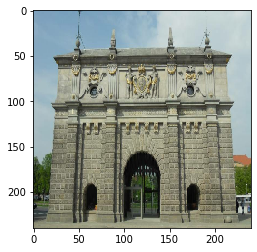

3 - Match index: 
Distance=0.4392759529858843


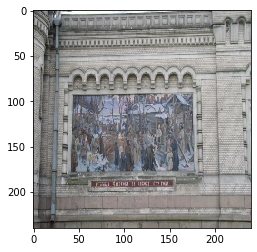

Query image: 


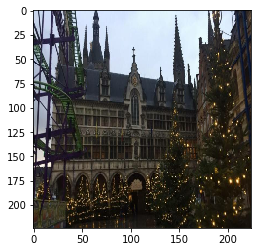

1 - Match index: 
Distance=0.5191243016883715


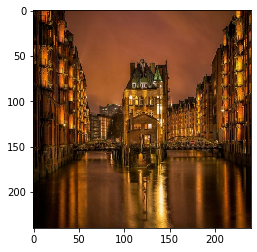

2 - Match index: 
Distance=0.5350753221222653


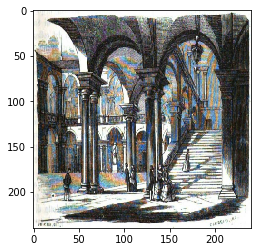

3 - Match index: 
Distance=0.5471921954935158


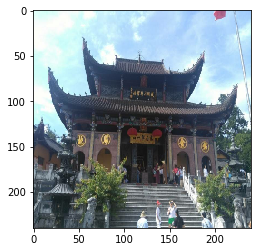

Query image: 


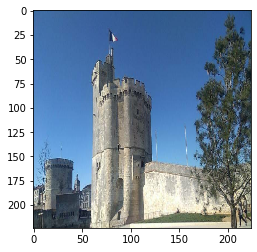

1 - Match index: 
Distance=0.5001863557517352


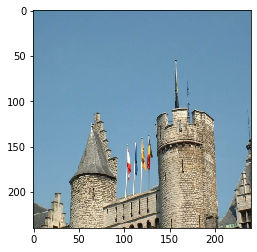

2 - Match index: 
Distance=0.5147313438305895


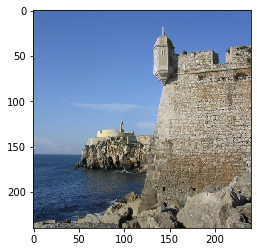

3 - Match index: 
Distance=0.5194820254288508


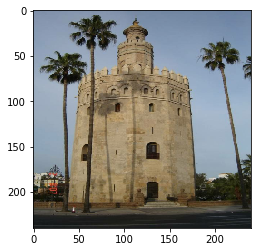

Query image: 


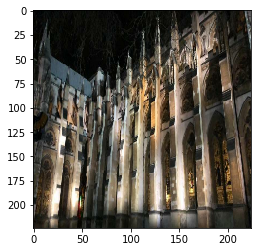

1 - Match index: 
Distance=0.49217026458856333


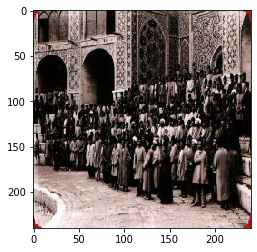

2 - Match index: 
Distance=0.5014222815903838


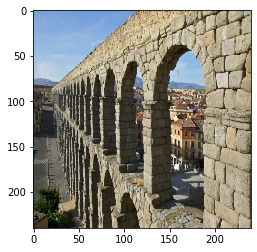

3 - Match index: 
Distance=0.5184988103687435


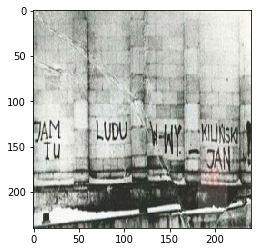

Query image: 


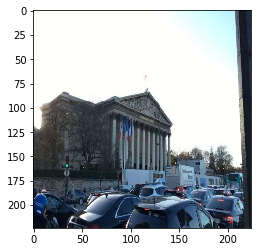

1 - Match index: 
Distance=0.5951770297680559


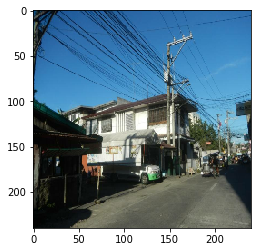

2 - Match index: 
Distance=0.6066661918927729


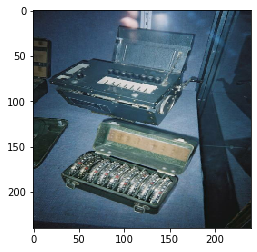

3 - Match index: 
Distance=0.6110407755707694


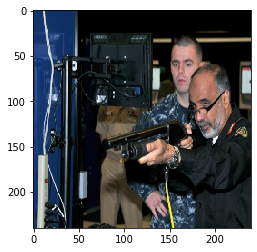

Query image: 


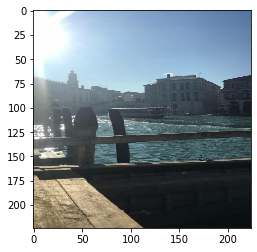

1 - Match index: 
Distance=0.5833193964237543


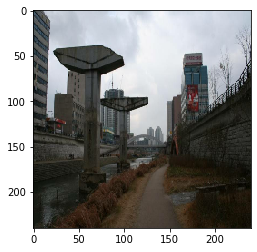

2 - Match index: 
Distance=0.6024189463643085


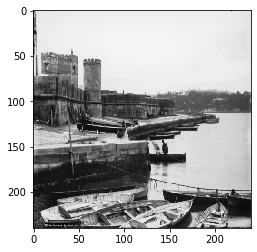

3 - Match index: 
Distance=0.6058308041954019


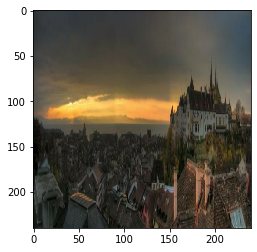

Query image: 


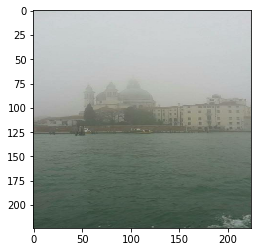

1 - Match index: 
Distance=0.4492544008672111


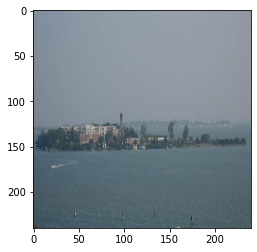

2 - Match index: 
Distance=0.4503847491113337


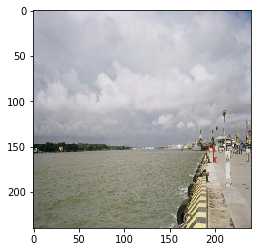

3 - Match index: 
Distance=0.46635581658852865


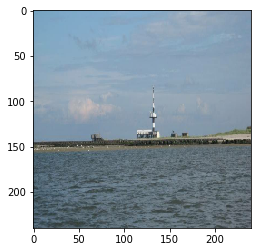

Query image: 


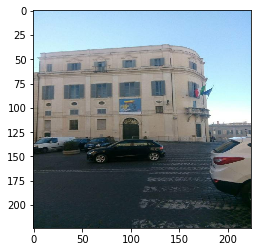

1 - Match index: 
Distance=0.520850504231377


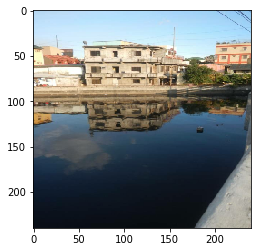

2 - Match index: 
Distance=0.5226488719866269


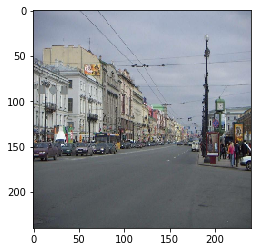

3 - Match index: 
Distance=0.5245123379557075


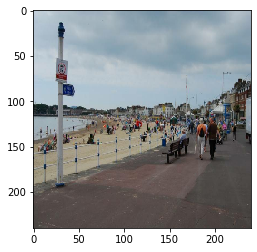

In [18]:
#######################################################################
# Evaluating the model
# Knn

# X_test_generator=predictDataset(test_paths, batch_size=32, img_size=img_size)
X_index_generator = predictDataset(index_paths, batch_size=64, img_size_load=img_size_load, 
                                       img_size_crop=img_size_crop)

# # query_embeddings = embedding_model.predict(X_test_generator)
index_embeddings = embedding_model.predict(X_index_generator)
# index_embeddings = tf.math.l2_normalize(index_embeddings).numpy()

knn = NearestNeighbors(n_neighbors=100, metric="euclidean")
knn.fit(index_embeddings)
indexes = [12, 78, 150, 200, 341, 679, 77<1, 897, 917, 999, 1098, 1128]

for query_index in indexes:
    query_img = decodeImage(test_paths[query_index], (img_size_crop[0], img_size_crop[1]), numpy=True)
    query_embedding = embedding_model.predict(np.expand_dims(query_img, axis=0))
#     query_embedding = tf.math.l2_normalize(query_embedding).numpy()
    distances, indices = knn.kneighbors(query_embedding)
    print('Query image: ')
    plt.imshow(query_img/255)
    plt.show()
    print('1 - Match index: ')
    print(f'Distance={distances.squeeze()[0]}')
    plt.imshow(decodeImage(index_paths[indices.squeeze()[0]])/255)
    plt.show()
    print('2 - Match index: ')
    print(f'Distance={distances.squeeze()[1]}')
    plt.imshow(decodeImage(index_paths[indices.squeeze()[1]])/255)
    plt.show()
    print('3 - Match index: ')
    print(f'Distance={distances.squeeze()[2]}')
    plt.imshow(decodeImage(index_paths[indices.squeeze()[2]])/255)
    plt.show()

#######################################################################

In [20]:
#######################################################################
# Submission

from zipfile import ZipFile

lr_model = LandmarkRetrievalModel(embedding_model, img_size_crop)
tf.saved_model.save(lr_model, './models/model', signatures={"serving_default" : lr_model.call})


with ZipFile('submission.zip','w') as output_zip_file:
    for filename in os.listdir('./models/model'):
        if os.path.isfile('./models/model/'+filename):
            output_zip_file.write('./models/model/'+filename, arcname=filename) 
    for filename in os.listdir('./models/model/variables'):
        if os.path.isfile('./models/model/variables/'+filename):
            output_zip_file.write('./models/model/variables/'+filename, arcname='variables/'+filename)
    for filename in os.listdir('./models/model/assets'):
        if os.path.isfile('./models/model/assets/'+filename):
            output_zip_file.write('./models/model/assets/'+filename, arcname='assets/'+filename)
            
#######################################################################

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model\assets
